In [9]:
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [10]:
# Connect to the SQLite database
conn = sqlite3.connect('database.sqlite')

# Query the database to retrieve data
query = "SELECT * FROM Player_attributes"

# Load the data into a pandas DataFrame
df = pd.read_sql_query(query, conn)

df.to_csv('Player_attributes.csv', index=False)

# Query the database to retrieve data
query = "SELECT * FROM Player"

# Load the data into a pandas DataFrame
df = pd.read_sql_query(query, conn)

df.to_csv('Players.csv', index=False)

# Close the database connection
conn.close()

DatabaseError: Execution failed on sql 'SELECT * FROM Player_attributes': no such table: Player_attributes

In [20]:
player_attributes = pd.read_csv('Player_attributes.csv')
players = pd.read_csv('Players.csv')
merged_df = pd.merge(player_attributes, players, on='player_fifa_api_id', how='inner')
merged_df = merged_df.drop(['id_x', 'id_y', 'player_api_id_x', 'player_api_id_y'], axis=1)
merged_df.head()

,player_fifa_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,...,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,birthday,height,weight
0,218353,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,...,69.0,6.0,11.0,10.0,8.0,8.0,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187
1,218353,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,...,69.0,6.0,11.0,10.0,8.0,8.0,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187
2,218353,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,44.0,71.0,...,69.0,6.0,11.0,10.0,8.0,8.0,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187
3,218353,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,...,66.0,5.0,10.0,9.0,7.0,7.0,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187
4,218353,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,...,66.0,5.0,10.0,9.0,7.0,7.0,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187


In [21]:
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df['birthday'] = pd.to_datetime(merged_df['birthday'])
merged_df['age'] = (merged_df['date'] - merged_df['birthday']).dt.days // 365
merged_df = merged_df.drop(['date', 'birthday'], axis=1)
merged_df['preferred_foot'] = merged_df['preferred_foot'].replace({'right': 0, 'left': 1})
merged_df.head()

C:\Users\tiany\AppData\Local\Temp\ipykernel_21300\4184450576.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df['preferred_foot'] = merged_df['preferred_foot'].replace({'right': 0, 'left': 1})


,player_fifa_api_id,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,...,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,height,weight,age
0,218353,67.0,71.0,0.0,medium,medium,49.0,44.0,71.0,61.0,...,69.0,6.0,11.0,10.0,8.0,8.0,Aaron Appindangoye,182.88,187,23
1,218353,67.0,71.0,0.0,medium,medium,49.0,44.0,71.0,61.0,...,69.0,6.0,11.0,10.0,8.0,8.0,Aaron Appindangoye,182.88,187,23
2,218353,62.0,66.0,0.0,medium,medium,49.0,44.0,71.0,61.0,...,69.0,6.0,11.0,10.0,8.0,8.0,Aaron Appindangoye,182.88,187,23
3,218353,61.0,65.0,0.0,medium,medium,48.0,43.0,70.0,60.0,...,66.0,5.0,10.0,9.0,7.0,7.0,Aaron Appindangoye,182.88,187,23
4,218353,61.0,65.0,0.0,medium,medium,48.0,43.0,70.0,60.0,...,66.0,5.0,10.0,9.0,7.0,7.0,Aaron Appindangoye,182.88,187,14


In [22]:
merged_df = merged_df.dropna().drop_duplicates()

# Remove possible GKs
player_attributes = merged_df[merged_df['gk_handling'] < 20]
len(player_attributes)

119538

## When number of x is less than 3, optimal k is not always 1. Multiple combinations of Xs were tried.

1
2
3
4
5
6
7
8
9
10


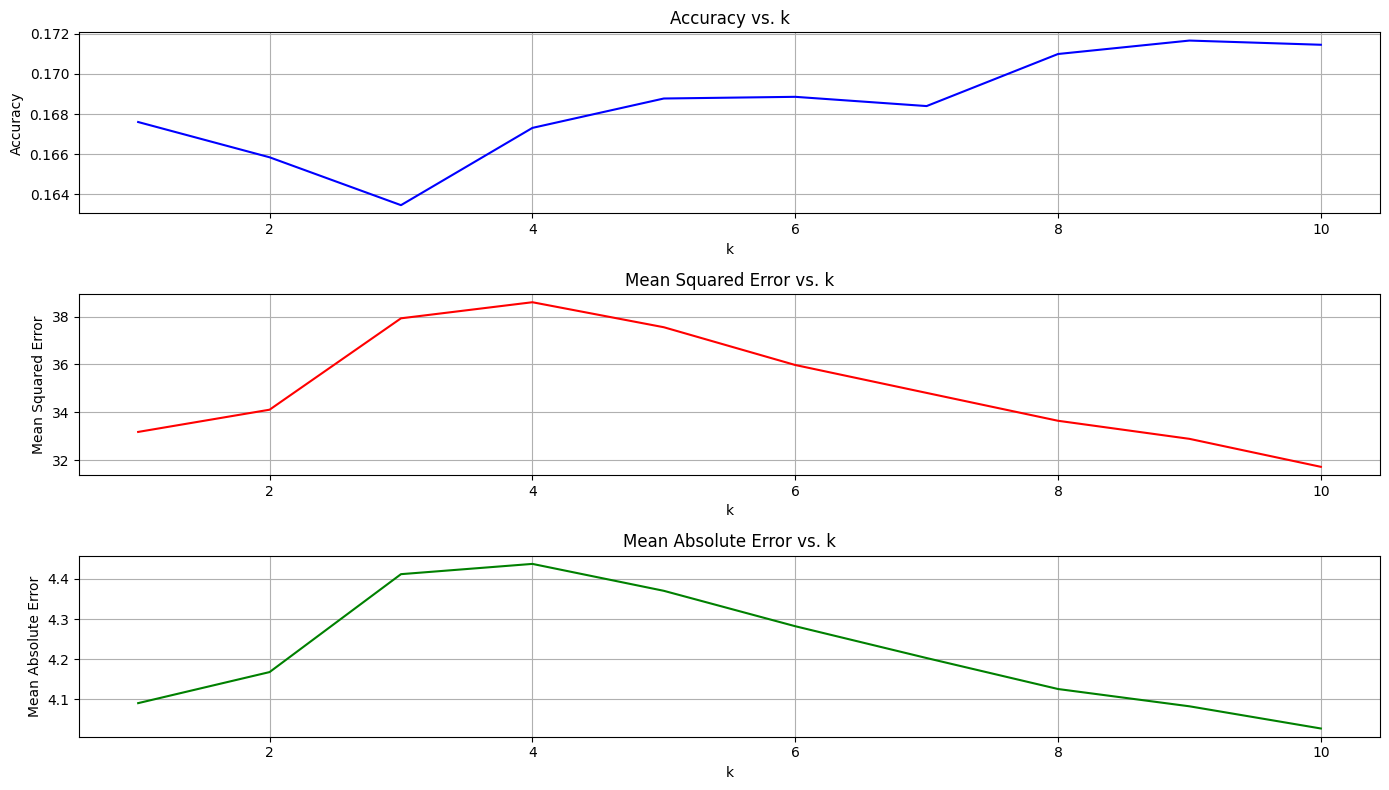

In [23]:
X = player_attributes[['weight', 'height', 'short_passing']]
y = player_attributes['overall_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

accuracies = []
mean_squared_errors = []
mean_absolute_errors = []

# Loop over k values from 1 to 10
for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Predict the test set
    y_pred = knn.predict(X_test)
    
    # Calculate the metrics
    accuracy = accuracy_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Append the metrics to the lists
    accuracies.append(accuracy)
    mean_squared_errors.append(mse)
    mean_absolute_errors.append(mae)
    print(k)
# Plotting the metrics
k_values = range(1, 11)
plt.figure(figsize=(14, 8))

# Plot accuracy
plt.subplot(3, 1, 1)
plt.plot(k_values, accuracies, label='Accuracy', color='b')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k')
plt.grid(True)

# Plot mean squared error
plt.subplot(3, 1, 2)
plt.plot(k_values, mean_squared_errors, label='Mean Squared Error', color='r')
plt.xlabel('k')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs. k')
plt.grid(True)

# Plot mean absolute error
plt.subplot(3, 1, 3)
plt.plot(k_values, mean_absolute_errors, label='Mean Absolute Error', color='g')
plt.xlabel('k')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error vs. k')
plt.grid(True)

plt.tight_layout()
plt.show()



## When number of x >= 3, optimal k is always 1. Multiple combinations of Xs were tried.

1
2
3
4
5
6
7
8
9
10


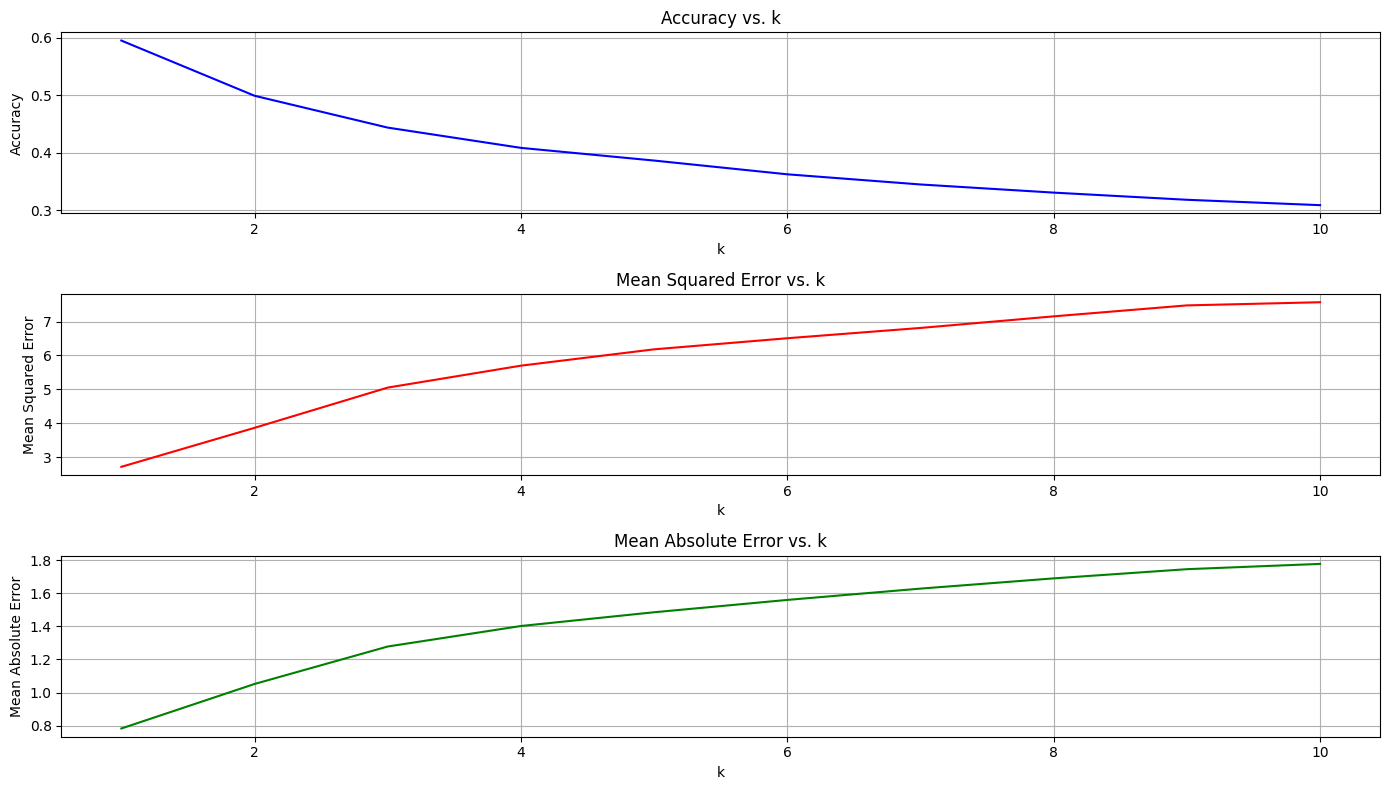

[65. 70. 67. ... 80. 69. 71.]


In [38]:

X = player_attributes[[ 'age', 'weight', 'height', 'short_passing', 'long_passing', 'dribbling', 'ball_control', 
                       'acceleration', 'reactions', 'balance', 'stamina', 'strength', 'vision']]
y = player_attributes['overall_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

accuracies = []
mean_squared_errors = []
mean_absolute_errors = []

# Loop over k values from 1 to 10
for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Predict the test set
    y_pred = knn.predict(X_test)
    
    # Calculate the metrics
    accuracy = accuracy_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Append the metrics to the lists
    accuracies.append(accuracy)
    mean_squared_errors.append(mse)
    mean_absolute_errors.append(mae)
    print(k)
# Plotting the metrics
k_values = range(1, 11)
plt.figure(figsize=(14, 8))

# Plot accuracy
plt.subplot(3, 1, 1)
plt.plot(k_values, accuracies, label='Accuracy', color='b')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k')
plt.grid(True)

# Plot mean squared error
plt.subplot(3, 1, 2)
plt.plot(k_values, mean_squared_errors, label='Mean Squared Error', color='r')
plt.xlabel('k')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs. k')
plt.grid(True)

# Plot mean absolute error
plt.subplot(3, 1, 3)
plt.plot(k_values, mean_absolute_errors, label='Mean Absolute Error', color='g')
plt.xlabel('k')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error vs. k')
plt.grid(True)

plt.tight_layout()
plt.show()





R2: 0.7752904440624439
Mean Squared Error: 10.210548688150135
Mean Absolute Error: 2.4682490889583364


<Axes: xlabel='overall_rating', ylabel='Count'>

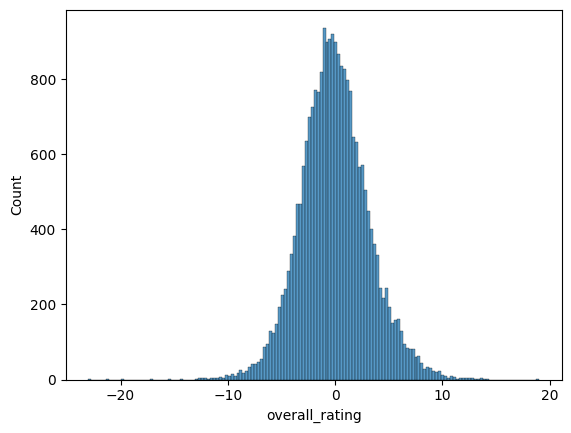

In [40]:
## logistic regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X = player_attributes[[ 'age', 'weight', 'height', 'short_passing', 'long_passing', 'dribbling', 'ball_control',
                          'acceleration', 'reactions', 'balance', 'stamina', 'strength', 'vision']]
y = player_attributes['overall_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

r2 = r2_score(y_test, y_pred)


mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print('R2:', r2)

print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)

import seaborn as sns
residual = y_test - y_pred
sns.histplot(residual)

In [41]:
print("y_test:", y_test)
print("y_pred:", y_pred)
print("residual:", residual)

y_test: 41553     64.0
111746    70.0
125771    66.0
110255    65.0
178501    70.0
          ... 
40850     75.0
167073    83.0
112422    84.0
25863     67.0
21949     70.0
Name: overall_rating, Length: 23908, dtype: float64
y_pred: [59.47082416 73.09236078 65.22448239 ... 78.9116023  64.25715948
 73.79346555]
residual: 41553     4.529176
111746   -3.092361
125771    0.775518
110255    1.036180
178501    3.279047
            ...   
40850     5.107102
167073    0.111642
112422    5.088398
25863     2.742841
21949    -3.793466
Name: overall_rating, Length: 23908, dtype: float64
